In [1]:
from darli.models.robot_model import RobotModel
import matplotlib.pyplot as plt
import casadi as cs
import numpy as np

In [2]:
# from robot_descriptions.loaders.yourdfpy import load_robot_description


In [3]:
from robot_descriptions import z1_description
darli_model = RobotModel(z1_description.URDF_PATH, bodies_names={'ee': 'link06'})

In [4]:
nq = darli_model.nq
nv = darli_model.nv
nu = darli_model.nu

### Variational Integrator

In [5]:
# Variables used in variational integrator 
q1 = cs.SX.sym('q1', darli_model.nq) # q_k-1
q2 = cs.SX.sym('q2', darli_model.nq) # q_k
q3 = cs.SX.sym('q3', darli_model.nq) # q_k+1
dT = cs.SX.sym('dt') # sampling time

# approximation of discrete Lagrangian
discrete_lagrangian =  cs.Function(f'discrete_lagrangian', [q1, q2, dT], 
                                   [darli_model.lagrangian((q1+q2)/2, (q2-q1)/dT)*dT], ['q1', 'q2', 'dt'], ['dL'])
# Slot derivatives wrt q1, q2
D1L = cs.Function(f'D1L', [q1, q2, dT], 
                  [cs.jacobian(discrete_lagrangian(q1, q2, dT), q1)], ['q1', 'q2', 'dt'], ['D1L']) 
D2L = cs.Function(f'D2L', [q1, q2, dT], 
                  [cs.jacobian(discrete_lagrangian(q1, q2, dT), q2)], ['q1', 'q2', 'dt'], ['D2L']) 

# Discrete Euler Lagrange residual (should be zero without inputs and auxiliary forces)
DEL_constraint = cs.Function(f'DEL',  [q1, q2, q3, dT],
                             [ D2L(q1, q2, dT).T + D1L(q2, q3, dT).T], 
                             ['q-1', 'q', 'q+1', 'dt'], ['DEL_residual']) 

Checkout the function:

In [6]:
DEL_constraint

Function(DEL:(q-1[6],q[6],q+1[6],dt)->(DEL_residual[6]) SXFunction)

### Optimal Control Problem  

Time intervals (nodes):

In [7]:
ns = 150  # number of shooting nodes
tf = 1.5  # [s]
dt = tf/ns

Create problem instance, configuration and control variables:

In [8]:
opti_problem = cs.Opti()
q = opti_problem.variable(ns, nq)
u = opti_problem.variable(ns-1, nv)

Introduce integrator constraints (Discrete EL and trapezoidal approximation for the control):

In [9]:
# Integrator constraints 
for i in range(1, ns-1):
    del_residual = DEL_constraint(q[i-1,:].T, q[i,:].T, q[i+1,:].T, dt)  
    del_control = (u[i-1,:].T + u[i,:].T)*dt/2
    opti_problem.subject_to(del_residual + del_control == 0)


Create parametric initial and final points (joint and cartesian spaces):

In [10]:
initial_configuration = opti_problem.parameter(6)
desired_pos = opti_problem.parameter(3)

Setup the boundary conditions:

In [11]:
# initial point (joint space)
opti_problem.subject_to(q[0,:].T == initial_configuration)
opti_problem.subject_to(q[0,:].T == q[1,:].T)
# Terminal point (cartesian space)
opti_problem.subject_to(darli_model.body('ee').position(q[-1,:]) == desired_pos)
opti_problem.subject_to(q[-1,:].T == q[-2,:].T)

Cost quadrature approximation:

In [12]:
# cost
cost = 0 

# stage cost 
for i in range(ns-1):
    cost += 1e-2*cs.sumsqr(q[i,:])*dt
    cost += 5e-2*cs.sumsqr((q[i+1,:] - q[i,:])/dt)*dt
    cost += 0.005*cs.sumsqr(u[i,:])*dt
    
# Terminal cost 
cost += 5e-2*cs.sumsqr(q[-1,:])
cost += 10e-2*cs.sumsqr((q[-1,:] - q[-2,:])/dt)


Setup the limits:

In [13]:
# Limits 
# joint limits 
opti_problem.subject_to(opti_problem.bounded(darli_model.q_min, q.T, darli_model.q_max))
# velocity limits
v_max = 1.5
qdot_lims = np.full((nv), v_max)
opti_problem.subject_to(opti_problem.bounded(-qdot_lims,(q[1:,:] - q[:-1,:]).T/dt,  qdot_lims))
# torque limits
u_max = 5
u_lims = np.full((nu), u_max) 
opti_problem.subject_to(opti_problem.bounded(-u_max, u.T,  u_max))

Define numerical values for the parameters and solve:

In [14]:
opti_problem.set_value(initial_configuration,np.zeros(6))
opti_problem.set_value(desired_pos,[0.2, 0.2, 0.36])

In [15]:
opti_problem.minimize(cost)
# opti_problem.solver('sqpmethod')
opti_problem.solver('ipopt')

In [16]:
sol = opti_problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    17804
Number of nonzeros in inequality constraint Jacobian.:     3582
Number of nonzeros in Lagrangian Hessian.............:     9408

Total number of variables............................:     1794
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      909
Total number of inequality c

In [17]:
# plt.spy(sol.value(cs.jacobian(opti_problem.g,opti_problem.x)))
# plt.show()

In [18]:
q_opt = opti_problem.value(q)
u_opt = opti_problem.value(u)
# q_opt

In [19]:
darli_model.body('ee').position(q_opt[-1]), opti_problem.value(desired_pos)

(DM([0.2, 0.2, 0.36]), array([0.2 , 0.2 , 0.36]))

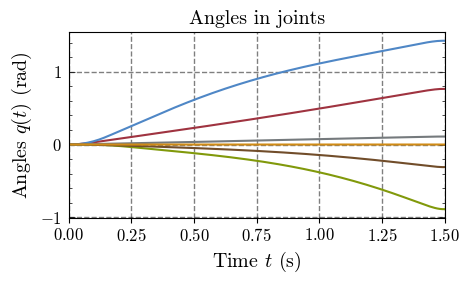

In [20]:
t = np.linspace(0, tf, ns)

plt.title(r'Angles in joints')
plt.plot(t, q_opt)
plt.grid(True)
plt.ylabel(r'Angles $q(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

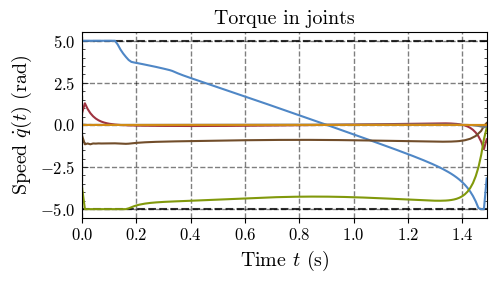

In [21]:

plt.title(r'Torque in joints')
plt.hlines(-u_max, 0, tf-dt, color = 'black', linestyle = '--', alpha = 0.8)
plt.hlines(u_max, 0, tf-dt, color = 'black', linestyle = '--', alpha = 0.8)
plt.plot(t[:-1], u_opt)
plt.grid(True)
plt.ylabel(r'Speed $\dot{q}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()